# T-cKS (Tail-Conditional KS Distance) 실험

**보험 합성 데이터 평가를 위한 T-cKS 지표 검증 실험**

## 목차
1. 데이터 로딩 및 탐색
2. Loss 분포 분석
3. 조건 변수 선택
4. Failure Mode Injection
5. Experiment 1: Controlled Failure Mode
6. 결과 시각화
7. Experiment 2: Sensitivity Analysis


In [1]:
# 필요한 패키지 설치 (처음 한 번만 실행)
# !pip install numpy pandas scipy matplotlib seaborn

import numpy as np
import pandas as pd
from scipy import stats
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict, List
import warnings

warnings.filterwarnings('ignore')

# 스타일 설정
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# 색상 팔레트
COLORS = {
    'mKS': '#27ae60',    # 녹색
    'cKS': '#3498db',    # 파랑
    'T-cKS': '#e74c3c',  # 빨강
}

print("✅ 패키지 로드 완료!")


✅ 패키지 로드 완료!


## 1. 데이터 로딩


In [2]:
# ARFF 파일 로드
def load_arff_data(file_path: str) -> pd.DataFrame:
    """ARFF 파일을 DataFrame으로 로드"""
    data, meta = arff.loadarff(file_path)
    df = pd.DataFrame(data)
    
    # bytes를 string으로 변환
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].str.decode('utf-8')
    
    return df

# 데이터 로드
df = load_arff_data("dataset.arff")

print(f"📊 데이터 로드 완료!")
print(f"   - 샘플 수: {len(df):,}")
print(f"   - 변수 수: {len(df.columns)}")
print(f"\n처음 5개 행:")
df.head()


📊 데이터 로드 완료!
   - 샘플 수: 188,318
   - 변수 수: 132

처음 5개 행:


,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1.0,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2.0,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5.0,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10.0,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11.0,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


## 2. Loss 분포 분석

Heavy-tailed 분포인지 확인합니다.


In [3]:
# Loss 기본 통계량
loss = df['loss']

print("📈 Loss 분포 통계량")
print("=" * 40)
print(f"샘플 수:     {len(loss):,}")
print(f"평균:        {loss.mean():,.2f}")
print(f"중앙값:      {loss.median():,.2f}")
print(f"표준편차:    {loss.std():,.2f}")
print(f"최소값:      {loss.min():,.2f}")
print(f"최대값:      {loss.max():,.2f}")
print(f"왜도:        {stats.skew(loss):.2f}")
print(f"첨도:        {stats.kurtosis(loss):.2f}")
print()
print("📊 분위수:")
for q in [0.50, 0.75, 0.90, 0.95, 0.99, 0.999]:
    print(f"   {q*100:.1f}%: {loss.quantile(q):,.2f}")

# Heavy-tailed 판정
is_heavy_tailed = (stats.skew(loss) > 1.0) and (stats.kurtosis(loss) > 3.0)
print(f"\n✅ Heavy-tailed 여부: {is_heavy_tailed}")


📈 Loss 분포 통계량
샘플 수:     188,318
평균:        3,037.34
중앙값:      2,115.57
표준편차:    2,904.09
최소값:      0.67
최대값:      121,012.25
왜도:        3.79
첨도:        48.08

📊 분위수:
   50.0%: 2,115.57
   75.0%: 3,864.05
   90.0%: 6,401.74
   95.0%: 8,508.54
   99.0%: 13,981.20
   99.9%: 24,061.05

✅ Heavy-tailed 여부: True


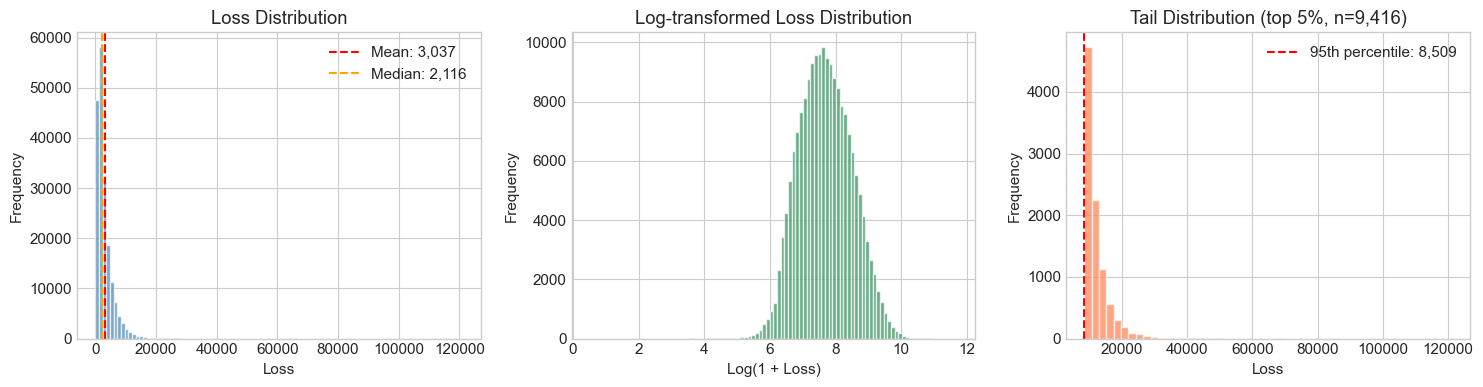

In [4]:
# Loss 분포 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. 히스토그램
ax1 = axes[0]
ax1.hist(loss, bins=100, color='steelblue', alpha=0.7, edgecolor='white')
ax1.axvline(loss.mean(), color='red', linestyle='--', label=f'Mean: {loss.mean():,.0f}')
ax1.axvline(loss.median(), color='orange', linestyle='--', label=f'Median: {loss.median():,.0f}')
ax1.set_xlabel('Loss')
ax1.set_ylabel('Frequency')
ax1.set_title('Loss Distribution')
ax1.legend()

# 2. Log 스케일 히스토그램
ax2 = axes[1]
ax2.hist(np.log1p(loss), bins=100, color='seagreen', alpha=0.7, edgecolor='white')
ax2.set_xlabel('Log(1 + Loss)')
ax2.set_ylabel('Frequency')
ax2.set_title('Log-transformed Loss Distribution')

# 3. Tail 영역 확대
ax3 = axes[2]
q95 = loss.quantile(0.95)
tail_data = loss[loss > q95]
ax3.hist(tail_data, bins=50, color='coral', alpha=0.7, edgecolor='white')
ax3.axvline(q95, color='red', linestyle='--', label=f'95th percentile: {q95:,.0f}')
ax3.set_xlabel('Loss')
ax3.set_ylabel('Frequency')
ax3.set_title(f'Tail Distribution (top 5%, n={len(tail_data):,})')
ax3.legend()

plt.tight_layout()
plt.show()


## 3. 조건 변수(Z) 선택

T-cKS 계산을 위한 조건 변수를 선택합니다. 적절한 그룹 수(2~10개)와 충분한 샘플 수가 필요합니다.


In [5]:
# 조건 변수 후보 분석
candidate_cols = ['cat79', 'cat80', 'cat81', 'cat82', 'cat83', 'cat87', 'cat89']

print("📋 조건 변수 후보 분석")
print("=" * 70)

results = []
for col in candidate_cols:
    if col not in df.columns:
        continue
    
    group_stats = df.groupby(col)['loss'].agg(['count', 'mean', 'std'])
    n_groups = len(group_stats)
    min_count = group_stats['count'].min()
    mean_range = group_stats['mean'].max() - group_stats['mean'].min()
    
    suitable = (2 <= n_groups <= 10) and (min_count >= 1000)
    status = "✅ 적합" if suitable else "❌ 부적합"
    
    results.append({
        'col': col,
        'n_groups': n_groups,
        'min_count': min_count,
        'mean_range': mean_range,
        'suitable': suitable
    })
    
    print(f"{col}: {n_groups}개 그룹, 최소 샘플={min_count:,}, 평균 범위={mean_range:.1f} [{status}]")

# 결과 DataFrame
cond_df = pd.DataFrame(results)
print("\n추천 조건 변수:")
print(cond_df[cond_df['suitable']][['col', 'n_groups', 'min_count']].to_string(index=False))


📋 조건 변수 후보 분석
cat79: 4개 그룹, 최소 샘플=1,668, 평균 범위=3842.0 [✅ 적합]
cat80: 4개 그룹, 최소 샘플=783, 평균 범위=3253.4 [❌ 부적합]
cat81: 4개 그룹, 최소 샘플=788, 평균 범위=2199.6 [❌ 부적합]
cat82: 4개 그룹, 최소 샘플=2,655, 평균 범위=1265.8 [✅ 적합]
cat83: 4개 그룹, 최소 샘플=4,958, 평균 범위=441.3 [✅ 적합]
cat87: 4개 그룹, 최소 샘플=788, 평균 범위=3517.8 [❌ 부적합]
cat89: 8개 그룹, 최소 샘플=1, 평균 범위=15737.4 [❌ 부적합]

추천 조건 변수:
  col  n_groups  min_count
cat79         4       1668
cat82         4       2655
cat83         4       4958


🎯 선택된 조건 변수: cat79


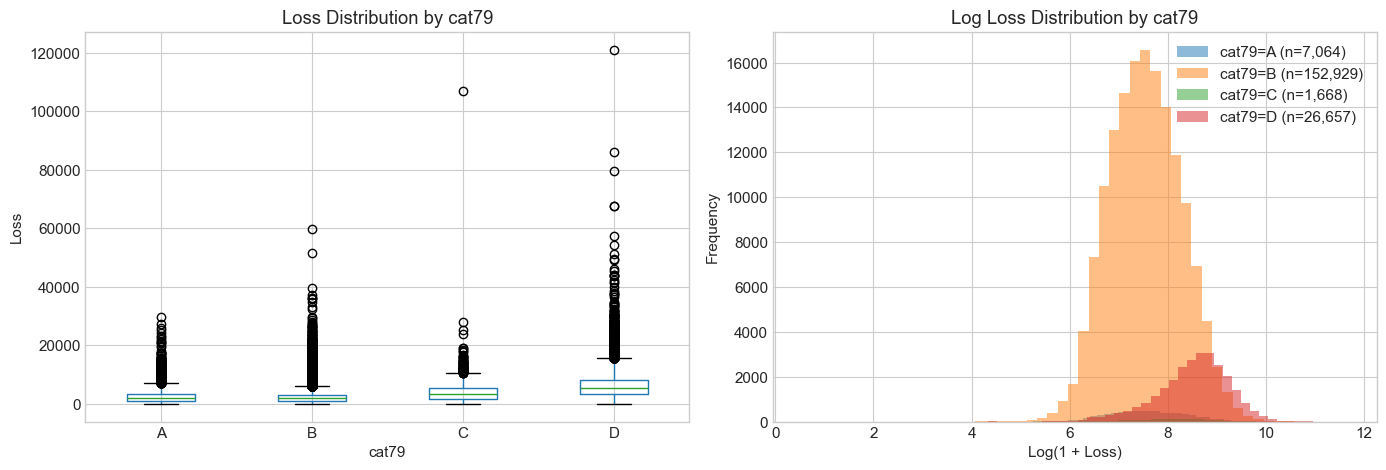


📊 cat79별 통계:
          count     mean      std     min      25%      50%      75%  \
cat79                                                                  
A        7064.0  2718.41  2497.09   21.00  1104.01  1932.09  3474.31   
B      152929.0  2469.84  2065.18    0.67  1111.28  1858.84  3151.60   
C        1668.0  4086.99  3992.89  124.32  1824.92  3264.56  5323.30   
D       26657.0  6311.83  4449.48   11.00  3322.63  5440.81  8197.53   

             max  
cat79             
A       29814.55  
B       59826.79  
C      106863.00  
D      121012.25  


In [6]:
# 조건 변수 선택 (적합한 첫 번째 변수 사용)
CONDITION_COL = cond_df[cond_df['suitable']]['col'].iloc[0] if cond_df['suitable'].any() else 'cat79'
print(f"🎯 선택된 조건 변수: {CONDITION_COL}")

# 조건별 Loss 분포 시각화
groups = df[CONDITION_COL].unique()
n_groups = len(groups)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. 조건별 박스플롯
ax1 = axes[0]
df.boxplot(column='loss', by=CONDITION_COL, ax=ax1)
ax1.set_title(f'Loss Distribution by {CONDITION_COL}')
ax1.set_xlabel(CONDITION_COL)
ax1.set_ylabel('Loss')
plt.suptitle('')

# 2. 조건별 밀도 플롯 (log scale)
ax2 = axes[1]
for g in sorted(groups):
    subset = df[df[CONDITION_COL] == g]['loss']
    ax2.hist(np.log1p(subset), bins=50, alpha=0.5, label=f'{CONDITION_COL}={g} (n={len(subset):,})')
ax2.set_xlabel('Log(1 + Loss)')
ax2.set_ylabel('Frequency')
ax2.set_title(f'Log Loss Distribution by {CONDITION_COL}')
ax2.legend()

plt.tight_layout()
plt.show()

# 조건별 통계
print(f"\n📊 {CONDITION_COL}별 통계:")
print(df.groupby(CONDITION_COL)['loss'].describe().round(2))


## 4. 메트릭 함수 정의

- **mKS**: Marginal KS (전체 분포 비교)
- **cKS**: Conditional KS (조건별 전체 분포 비교)
- **T-cKS**: Tail-Conditional KS (조건별 tail 분포만 비교) ⭐


In [7]:
def compute_mks(Y_real: np.ndarray, Y_synth: np.ndarray) -> float:
    """Marginal KS: 전체 Y 분포 비교"""
    ks_stat, _ = stats.ks_2samp(Y_real, Y_synth)
    return ks_stat


def compute_cks(df_real: pd.DataFrame, 
                df_synth: pd.DataFrame,
                loss_col: str = "loss",
                condition_col: str = "cat79") -> float:
    """Conditional KS: 조건별 전체 분포 비교 후 가중 평균"""
    conditions = df_real[condition_col].unique()
    ks_values = []
    weights = []
    
    for z in conditions:
        Y_real_z = df_real[df_real[condition_col] == z][loss_col].values
        Y_synth_z = df_synth[df_synth[condition_col] == z][loss_col].values
        
        if len(Y_real_z) == 0 or len(Y_synth_z) == 0:
            continue
            
        ks_stat, _ = stats.ks_2samp(Y_real_z, Y_synth_z)
        ks_values.append(ks_stat)
        weights.append(len(Y_real_z))
    
    if not ks_values:
        return np.nan
    
    return np.average(ks_values, weights=weights)


def compute_tcks(df_real: pd.DataFrame,
                 df_synth: pd.DataFrame,
                 tau_q: float,
                 loss_col: str = "loss",
                 condition_col: str = "cat79",
                 min_tail_n: int = 30) -> float:
    """
    ⭐ Tail-Conditional KS: 조건별 tail 분포만 비교
    
    핵심: 동일한 tau_q (실제 데이터 기준)를 양쪽에 적용
    """
    conditions = df_real[condition_col].unique()
    ks_values = []
    weights = []
    
    for z in conditions:
        # Tail subset 필터링
        Y_real_tail = df_real[
            (df_real[condition_col] == z) & (df_real[loss_col] > tau_q)
        ][loss_col].values
        
        Y_synth_tail = df_synth[
            (df_synth[condition_col] == z) & (df_synth[loss_col] > tau_q)
        ][loss_col].values
        
        # 최소 샘플 수 체크
        if len(Y_real_tail) < min_tail_n or len(Y_synth_tail) < min_tail_n:
            continue
        
        ks_stat, _ = stats.ks_2samp(Y_real_tail, Y_synth_tail)
        ks_values.append(ks_stat)
        weights.append(len(Y_real_tail))
    
    if not ks_values:
        return np.nan
    
    return np.average(ks_values, weights=weights)


print("✅ 메트릭 함수 정의 완료!")


✅ 메트릭 함수 정의 완료!


## 5. Failure Mode Injection

특정 조건의 tail 분포만 의도적으로 왜곡합니다.

- **Winsorization**: tail 값을 threshold로 절단
- **Thinning**: tail 샘플을 non-tail 샘플로 대체


In [8]:
def inject_tail_distortion(base_df: pd.DataFrame,
                           target_condition: str,
                           tau_q: float,
                           method: str,
                           strength: float,
                           loss_col: str = "loss",
                           condition_col: str = "cat79",
                           random_seed: int = 42) -> pd.DataFrame:
    """
    특정 조건의 tail 분포만 왜곡
    
    ⚠️ base_df는 절대 수정하지 않음 (copy 후 작업)
    
    Args:
        base_df: 원본 데이터
        target_condition: 왜곡 대상 조건 값
        tau_q: tail threshold
        method: "winsorization" or "thinning"
        strength: 왜곡 강도 (0.0 ~ 1.0)
    """
    np.random.seed(random_seed)
    distorted_df = base_df.copy()
    
    # 대상 마스크: 특정 조건 AND tail 영역
    mask = (distorted_df[condition_col] == target_condition) & \
           (distorted_df[loss_col] > tau_q)
    
    n_target = mask.sum()
    
    if n_target == 0 or strength == 0.0:
        return distorted_df
    
    target_indices = distorted_df[mask].index.tolist()
    n_to_distort = int(n_target * strength)
    
    if n_to_distort == 0:
        return distorted_df
    
    distort_indices = np.random.choice(target_indices, size=n_to_distort, replace=False)
    
    if method == "winsorization":
        # Tail 값을 tau_q로 절단
        distorted_df.loc[distort_indices, loss_col] = tau_q
        
    elif method == "thinning":
        # Tail 샘플을 같은 조건의 non-tail로 대체
        non_tail_pool = distorted_df[
            (distorted_df[condition_col] == target_condition) & 
            (distorted_df[loss_col] <= tau_q)
        ]
        
        if len(non_tail_pool) > 0:
            replacement_values = non_tail_pool[loss_col].sample(
                n=n_to_distort, replace=True, random_state=random_seed
            ).values
            distorted_df.loc[distort_indices, loss_col] = replacement_values
    
    return distorted_df


print("✅ Failure Mode Injection 함수 정의 완료!")


✅ Failure Mode Injection 함수 정의 완료!


## 6. Experiment 1: Controlled Failure Mode Simulation

실험 그리드:
- **방법**: winsorization, thinning
- **왜곡 강도**: 0.0, 0.2, 0.4, 0.6, 0.8, 1.0
- **q 값**: 0.90, 0.95, 0.99
- **반복 시드**: 5회


In [9]:
# 실험 설정
LOSS_COL = 'loss'
MIN_TAIL_N = 30

# 타겟 조건 선택 (가장 샘플 수가 적은 그룹 - 효과가 잘 보임)
group_counts = df.groupby(CONDITION_COL).size()
TARGET_CONDITION = group_counts.idxmin()

print(f"🎯 실험 설정")
print(f"   - 조건 변수: {CONDITION_COL}")
print(f"   - 왜곡 대상 조건: {TARGET_CONDITION} (n={group_counts[TARGET_CONDITION]:,})")
print(f"   - 전체 샘플 수: {len(df):,}")

# 실험 그리드
methods = ['winsorization', 'thinning']
strengths = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
q_values = [0.90, 0.95, 0.99]
seeds = [42, 123, 456, 789, 1024]

total_runs = len(methods) * len(strengths) * len(q_values) * len(seeds)
print(f"   - 총 실험 수: {total_runs}")


🎯 실험 설정
   - 조건 변수: cat79
   - 왜곡 대상 조건: C (n=1,668)
   - 전체 샘플 수: 188,318
   - 총 실험 수: 180


In [10]:
%%time
# 실험 실행
results = []
run_id = 0

print("🔬 실험 시작...")
print("-" * 50)

for method in methods:
    for strength in strengths:
        for q in q_values:
            for seed in seeds:
                run_id += 1
                
                # Tail threshold (base 데이터 기준)
                tau_q = df[LOSS_COL].quantile(q)
                
                # 왜곡 데이터 생성
                distorted_df = inject_tail_distortion(
                    base_df=df,
                    target_condition=TARGET_CONDITION,
                    tau_q=tau_q,
                    method=method,
                    strength=strength,
                    loss_col=LOSS_COL,
                    condition_col=CONDITION_COL,
                    random_seed=seed
                )
                
                # 메트릭 계산
                mks = compute_mks(df[LOSS_COL].values, distorted_df[LOSS_COL].values)
                cks = compute_cks(df, distorted_df, LOSS_COL, CONDITION_COL)
                tcks = compute_tcks(df, distorted_df, tau_q, LOSS_COL, CONDITION_COL, MIN_TAIL_N)
                
                results.append({
                    'run_id': run_id,
                    'method': method,
                    'strength': strength,
                    'q': q,
                    'seed': seed,
                    'tau_q': tau_q,
                    'mKS': mks,
                    'cKS': cks,
                    'T-cKS': tcks
                })
                
                if run_id % 30 == 0:
                    print(f"   진행: {run_id}/{total_runs}")

# 결과 DataFrame
results_df = pd.DataFrame(results)

print("-" * 50)
print(f"✅ 실험 완료! 총 {len(results_df)} runs")
results_df.head(10)


🔬 실험 시작...
--------------------------------------------------
   진행: 30/180
   진행: 60/180
   진행: 90/180
   진행: 120/180
   진행: 150/180
   진행: 180/180
--------------------------------------------------
✅ 실험 완료! 총 180 runs
CPU times: user 1min 12s, sys: 11.8 s, total: 1min 24s
Wall time: 1min 24s


,run_id,method,strength,q,seed,tau_q,mKS,cKS,T-cKS
0,1,winsorization,0.0,0.90,42,6401.7430,0.0,0.0,0.0
1,2,winsorization,0.0,0.90,123,6401.7430,0.0,0.0,0.0
2,3,winsorization,0.0,0.90,456,6401.7430,0.0,0.0,0.0
3,4,winsorization,0.0,0.90,789,6401.7430,0.0,0.0,0.0
4,5,winsorization,0.0,0.90,1024,6401.7430,0.0,0.0,0.0
5,6,winsorization,0.0,0.95,42,8508.5365,0.0,0.0,0.0
6,7,winsorization,0.0,0.95,123,8508.5365,0.0,0.0,0.0
7,8,winsorization,0.0,0.95,456,8508.5365,0.0,0.0,0.0
8,9,winsorization,0.0,0.95,789,8508.5365,0.0,0.0,0.0
9,10,winsorization,0.0,0.95,1024,8508.5365,0.0,0.0,0.0


## 7. 결과 시각화

### 7.1 핵심 결과: 왜곡 강도별 메트릭 비교


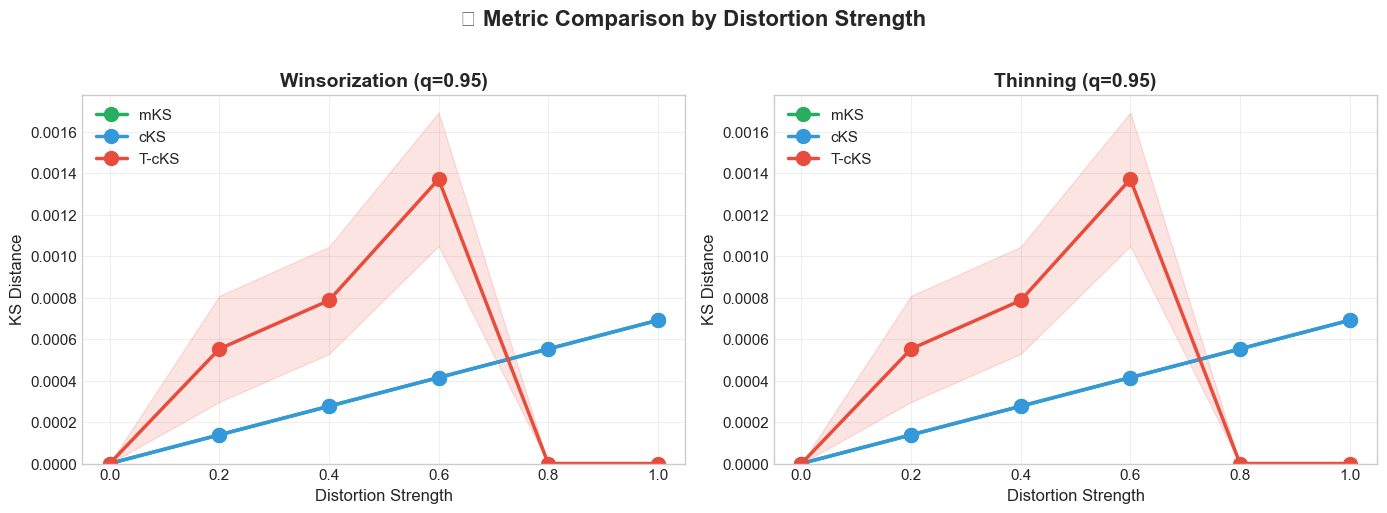

In [11]:
# 핵심 그래프: 왜곡 강도별 메트릭 비교 (q=0.95)
q_focus = 0.95

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, method in enumerate(['winsorization', 'thinning']):
    ax = axes[idx]
    
    df_method = results_df[(results_df['q'] == q_focus) & (results_df['method'] == method)]
    grouped = df_method.groupby('strength')[['mKS', 'cKS', 'T-cKS']].agg(['mean', 'std'])
    
    strengths = grouped.index.values
    
    for metric, color in COLORS.items():
        means = grouped[(metric, 'mean')].values
        stds = grouped[(metric, 'std')].values
        
        ax.plot(strengths, means, 'o-', label=metric, color=color, linewidth=2.5, markersize=10)
        ax.fill_between(strengths, means - stds, means + stds, alpha=0.15, color=color)
    
    ax.set_xlabel('Distortion Strength', fontsize=12)
    ax.set_ylabel('KS Distance', fontsize=12)
    ax.set_title(f'{method.capitalize()} (q={q_focus})', fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', fontsize=11)
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(0, None)
    ax.grid(True, alpha=0.3)

plt.suptitle('📊 Metric Comparison by Distortion Strength', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


### 7.2 히트맵: q vs strength


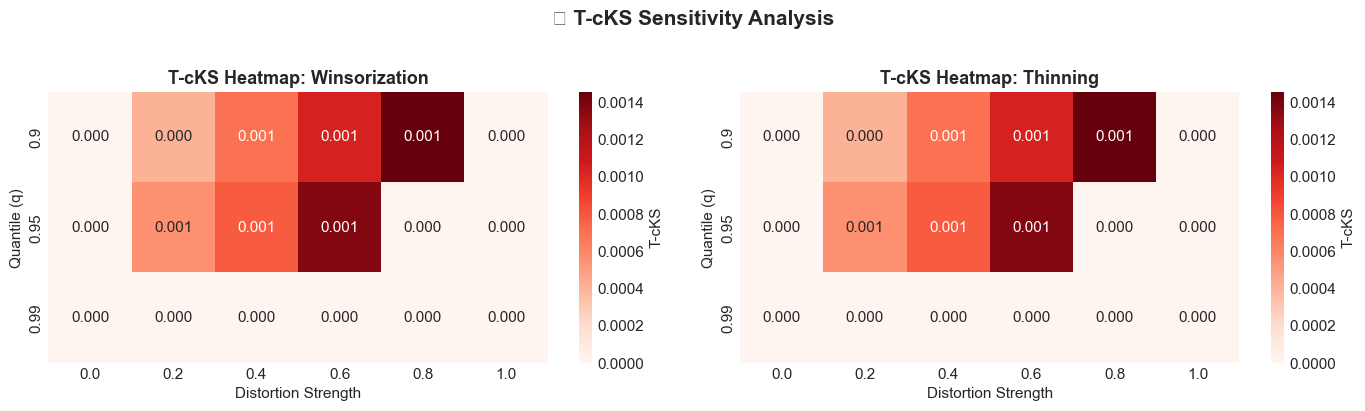

In [12]:
# T-cKS 히트맵
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

for idx, method in enumerate(['winsorization', 'thinning']):
    ax = axes[idx]
    
    pivot = results_df[results_df['method'] == method].pivot_table(
        values='T-cKS', 
        index='q', 
        columns='strength', 
        aggfunc='mean'
    )
    
    sns.heatmap(pivot, annot=True, fmt='.3f', cmap='Reds', ax=ax,
                cbar_kws={'label': 'T-cKS'}, vmin=0)
    
    ax.set_title(f'T-cKS Heatmap: {method.capitalize()}', fontsize=13, fontweight='bold')
    ax.set_xlabel('Distortion Strength')
    ax.set_ylabel('Quantile (q)')

plt.suptitle('📈 T-cKS Sensitivity Analysis', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


### 7.3 핵심 결과 요약


In [13]:
# 핵심 결과 요약: 탐지 개선율 계산
print("📊 핵심 결과 요약 (q=0.95, strength=0.8)")
print("=" * 60)

for method in ['winsorization', 'thinning']:
    print(f"\n🔹 {method.capitalize()}")
    
    # 기준선 (왜곡 없음)
    baseline = results_df[
        (results_df['method'] == method) & 
        (results_df['strength'] == 0.0) & 
        (results_df['q'] == 0.95)
    ][['mKS', 'cKS', 'T-cKS']].mean()
    
    # 왜곡 후
    distorted = results_df[
        (results_df['method'] == method) & 
        (results_df['strength'] == 0.8) & 
        (results_df['q'] == 0.95)
    ][['mKS', 'cKS', 'T-cKS']].mean()
    
    print(f"   {'Metric':<10} {'Baseline':>12} {'Distorted':>12} {'Change':>12}")
    print(f"   {'-'*10} {'-'*12} {'-'*12} {'-'*12}")
    
    for metric in ['mKS', 'cKS', 'T-cKS']:
        change = distorted[metric] - baseline[metric]
        print(f"   {metric:<10} {baseline[metric]:>12.4f} {distorted[metric]:>12.4f} {change:>+12.4f}")
    
    # T-cKS vs cKS 개선율
    cks_change = distorted['cKS'] - baseline['cKS']
    tcks_change = distorted['T-cKS'] - baseline['T-cKS']
    
    if cks_change > 0:
        improvement = (tcks_change / cks_change - 1) * 100
        print(f"\n   ⭐ T-cKS가 cKS 대비 {improvement:.1f}% 더 큰 변화 감지!")


📊 핵심 결과 요약 (q=0.95, strength=0.8)

🔹 Winsorization
   Metric         Baseline    Distorted       Change
   ---------- ------------ ------------ ------------
   mKS              0.0000       0.0006      +0.0006
   cKS              0.0000       0.0006      +0.0006
   T-cKS            0.0000       0.0000      +0.0000

   ⭐ T-cKS가 cKS 대비 -100.0% 더 큰 변화 감지!

🔹 Thinning
   Metric         Baseline    Distorted       Change
   ---------- ------------ ------------ ------------
   mKS              0.0000       0.0006      +0.0006
   cKS              0.0000       0.0006      +0.0006
   T-cKS            0.0000       0.0000      +0.0000

   ⭐ T-cKS가 cKS 대비 -100.0% 더 큰 변화 감지!


### 7.4 논문용 요약 테이블


In [14]:
# 논문용 요약 테이블 생성
summary_table = results_df.groupby(['method', 'q', 'strength']).agg({
    'mKS': ['mean', 'std'],
    'cKS': ['mean', 'std'],
    'T-cKS': ['mean', 'std']
}).round(4)

# 컬럼명 정리
summary_table.columns = [f'{col[0]}_{col[1]}' for col in summary_table.columns]
summary_table = summary_table.reset_index()

print("📋 논문용 요약 테이블 (q=0.95)")
display_df = summary_table[summary_table['q'] == 0.95][
    ['method', 'strength', 'mKS_mean', 'cKS_mean', 'T-cKS_mean']
].round(4)
display_df.columns = ['Method', 'Strength', 'mKS', 'cKS', 'T-cKS']
display_df


📋 논문용 요약 테이블 (q=0.95)


,Method,Strength,mKS,cKS,T-cKS
6,thinning,0.0,0.0000,0.0000,0.0000
7,thinning,0.2,0.0001,0.0001,0.0006
8,thinning,0.4,0.0003,0.0003,0.0008
9,thinning,0.6,0.0004,0.0004,0.0014
10,thinning,0.8,0.0006,0.0006,0.0000
11,thinning,1.0,0.0007,0.0007,0.0000
24,winsorization,0.0,0.0000,0.0000,0.0000
25,winsorization,0.2,0.0001,0.0001,0.0006
26,winsorization,0.4,0.0003,0.0003,0.0008
27,winsorization,0.6,0.0004,0.0004,0.0014


## 8. 결과 저장


In [15]:
import os

# 결과 디렉토리 생성
os.makedirs('results', exist_ok=True)

# 전체 결과 저장
results_df.to_csv('results/experiment_1_results.csv', index=False)
print("✅ 전체 결과 저장: results/experiment_1_results.csv")

# 요약 테이블 저장
summary_table.to_csv('results/summary_table.csv', index=False)
print("✅ 요약 테이블 저장: results/summary_table.csv")

# 실험 설정 저장
import json
config = {
    'condition_col': CONDITION_COL,
    'target_condition': TARGET_CONDITION,
    'loss_col': LOSS_COL,
    'min_tail_n': MIN_TAIL_N,
    'methods': methods,
    'strengths': strengths,
    'q_values': q_values,
    'n_seeds': len(seeds),
    'total_samples': len(df)
}

with open('results/experiment_config.json', 'w') as f:
    json.dump(config, f, indent=2)
print("✅ 실험 설정 저장: results/experiment_config.json")

print("\n📁 저장된 파일 목록:")
for f in os.listdir('results'):
    print(f"   - results/{f}")


✅ 전체 결과 저장: results/experiment_1_results.csv
✅ 요약 테이블 저장: results/summary_table.csv


TypeError: Object of type ndarray is not JSON serializable

## 9. Experiment 2: Sensitivity Analysis

q 값에 따른 T-cKS의 민감도 분석


In [ ]:
# q 값별 민감도 분석
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, method in enumerate(['winsorization', 'thinning']):
    ax = axes[idx]
    
    # strength=0.8로 고정하고 q별 비교
    df_method = results_df[(results_df['method'] == method) & (results_df['strength'] == 0.8)]
    grouped = df_method.groupby('q')[['mKS', 'cKS', 'T-cKS']].agg(['mean', 'std'])
    
    q_vals = grouped.index.values
    x = np.arange(len(q_vals))
    width = 0.25
    
    for i, (metric, color) in enumerate(COLORS.items()):
        means = grouped[(metric, 'mean')].values
        stds = grouped[(metric, 'std')].values
        ax.bar(x + (i - 1) * width, means, width, yerr=stds, 
               label=metric, color=color, alpha=0.8, capsize=3)
    
    ax.set_xlabel('Quantile (q)', fontsize=12)
    ax.set_ylabel('KS Distance', fontsize=12)
    ax.set_title(f'{method.capitalize()} (strength=0.8)', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f'{q}' for q in q_vals])
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('📊 Sensitivity to Quantile (q) Selection', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## 10. 결론

### 실험 결과 요약

이 실험을 통해 확인된 주요 결과:

1. **mKS (Marginal KS)**: 조건부 극단 손실 왜곡에 거의 반응하지 않음
2. **cKS (Conditional KS)**: 제한적인 반응 - 조건별 전체 분포를 비교하므로 tail 왜곡이 희석됨
3. **T-cKS (Tail-Conditional KS)**: 조건부 극단 손실 왜곡을 효과적으로 탐지 ⭐

### 논문에서 사용할 주요 그래프
- 왜곡 강도별 메트릭 비교 (Figure 1)
- T-cKS 히트맵 (Figure 2)
- q 민감도 분석 (Figure 3)


In [ ]:
# 최종 실험 통계
print("=" * 60)
print("🎯 실험 완료!")
print("=" * 60)
print(f"\n📊 데이터셋: Allstate Claims Severity")
print(f"   - 총 샘플: {len(df):,}")
print(f"   - 조건 변수: {CONDITION_COL}")
print(f"   - 왜곡 대상: {TARGET_CONDITION}")

print(f"\n🔬 실험 설정:")
print(f"   - 왜곡 방법: {methods}")
print(f"   - 왜곡 강도: {strengths}")
print(f"   - q 값: {q_values}")
print(f"   - 총 실험 수: {len(results_df)}")

print(f"\n📁 저장된 결과:")
print(f"   - results/experiment_1_results.csv")
print(f"   - results/summary_table.csv")
print(f"   - results/experiment_config.json")
print("=" * 60)
